In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [3]:
data = pd.read_pickle("./datasets/archive/std_gray.pickle")
data.keys()

dict_keys(['std_gray'])

In [4]:
print(data["std_gray"].shape)

(1, 32, 32)


(32, 32, 1)


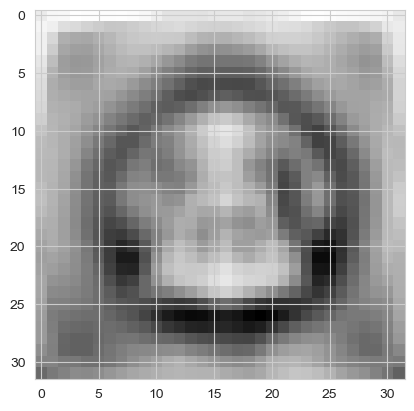

In [5]:
data["std_gray"]=data["std_gray"].swapaxes(0, 1)
data["std_gray"]=data["std_gray"].swapaxes(1, 2)
print(data["std_gray"].shape)
plt.imshow(data["std_gray"], cmap="gray")

In [6]:
train = pd.read_pickle("./datasets/archive/train.pickle")
train.keys()

dict_keys(['coords', 'labels', 'features', 'sizes'])

In [7]:
print(train["features"].shape)

(34799, 32, 32, 3)


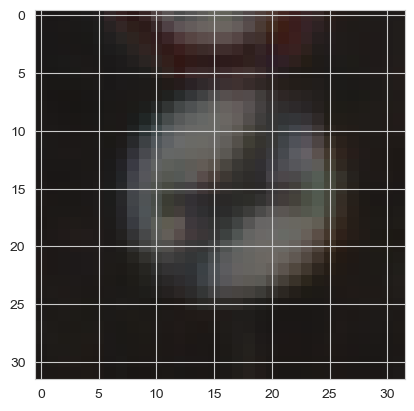

In [8]:
plt.imshow(train["features"][1])

In [9]:
print(train["labels"].shape)

(34799,)


In [10]:
print(train["labels"][1])

41


In [11]:
#precessing
print(train["coords"].shape)

(34799, 4)


In [12]:
print(train["coords"][1])

[ 6  6 22 22]


In [17]:

import cv2
import os
from pathlib import Path

def convert_to_yolo(data_dict, output_dir):
    """
    Convert dataset to YOLO format
    
    Args:
        data_dict: Dictionary containing features, train, coords
        output_dir: Output directory for YOLO format files
    """
    # Create output directories
    images_dir = Path(output_dir) / "images/val"
    labels_dir = Path(output_dir) / "labels/val" 
    
    images_dir.mkdir(parents=True, exist_ok=True)
    labels_dir.mkdir(parents=True, exist_ok=True)

    features = data_dict["features"]  # (N, 32, 32, 3)
    labels = data_dict["labels"]      # (N,)
    coords = data_dict["coords"]      # (N, 4) [x1,y1,x2,y2]
    
    img_height, img_width = features.shape[1:3]
    
    for idx in range(len(features)):
        # Save image
        img = features[idx]
        img_path = images_dir / f"image_{idx:06d}.png"
        cv2.imwrite(str(img_path), img)
        
        # Convert coordinates to YOLO format
        x1, y1, x2, y2 = coords[idx]
        
        # Calculate center coordinates and width/height
        x_center = (x1 + x2) / 2
        y_center = (y1 + y2) / 2
        width = x2 - x1
        height = y2 - y1
        
        # Normalize coordinates
        x_center = x_center / img_width
        y_center = y_center / img_height
        width = width / img_width
        height = height / img_height
        
        # Save label file
        label = labels[idx]
        label_path = labels_dir / f"image_{idx:06d}.txt"
        
        with open(label_path, 'w') as f:
            # YOLO format: <class> <x_center> <y_center> <width> <height>
            f.write(f"{label} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}")

    # Create dataset.yaml
    num_classes = len(np.unique(labels))
    class_names = [f"class_{i}" for i in range(num_classes)]
    class_names_str = str(class_names).replace("'", "")  # Remove quotes for YAML format
    
#     yaml_content = f"""path: {output_dir}
# train: train/train
# val: train/val
# test: train/test
# 
# nc: {num_classes}  # number of classes
# names: {class_names_str}  # class names
# """
#     
#     with open(Path(output_dir) / "dataset.yaml", 'w') as f:
#         f.write(yaml_content)

# Usage example:
# output_dir = "./yolo_dataset"
# convert_to_yolo(train, output_dir)

In [22]:
output_dir = "./yolo_dataset"
val = pd.read_pickle("./datasets/archive/valid.pickle")
val.keys()
print(val["features"].shape)
convert_to_yolo(val, output_dir)

(4410, 32, 32, 3)


In [7]:
import cv2
import os
from pathlib import Path
def convert_to_yolo(data_dict, output_dir):
    """
    Convert dataset to YOLO format with proper coordinate normalization
    
    Args:
        data_dict: Dictionary containing features, labels, coords
        output_dir: Output directory for YOLO format files
    """
    # Create output directories
    images_dir = Path(output_dir) / "images/val"
    labels_dir = Path(output_dir) / "labels/val" 
    
    images_dir.mkdir(parents=True, exist_ok=True)
    labels_dir.mkdir(parents=True, exist_ok=True)

    features = data_dict["features"]  # (N, 32, 32, 3)
    labels = data_dict["labels"]      # (N,)
    coords = data_dict["coords"]      # (N, 4) [x1,y1,x2,y2]
    
    img_height, img_width = features.shape[1:3]
    
    for idx in range(len(features)):
        # Save image
        img = features[idx]
        img_path = images_dir / f"image_{idx:06d}.png"
        cv2.imwrite(str(img_path), img)
        
        # Convert coordinates to YOLO format
        x1, y1, x2, y2 = map(float, coords[idx])
        
        # Ensure coordinates are within image bounds
        x1 = max(0, min(x1, img_width))
        x2 = max(0, min(x2, img_width))
        y1 = max(0, min(y1, img_height))
        y2 = max(0, min(y2, img_height))
        
        # Calculate center coordinates and width/height
        x_center = (x1 + x2) / 2.0
        y_center = (y1 + y2) / 2.0
        width = max(0, x2 - x1)  # ensure positive width
        height = max(0, y2 - y1)  # ensure positive height
        
        # Normalize coordinates and clamp between 0 and 1
        x_center = max(0.0, min(1.0, x_center / float(img_width)))
        y_center = max(0.0, min(1.0, y_center / float(img_height)))
        width = max(0.0, min(1.0, width / float(img_width)))
        height = max(0.0, min(1.0, height / float(img_height)))
        
        # Save label file
        label = labels[idx]
        label_path = labels_dir / f"image_{idx:06d}.txt"
        
        with open(label_path, 'w') as f:
            # YOLO format: <class> <x_center> <y_center> <width> <height>
            f.write(f"{label} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}")
    
    print(f"Converted {len(features)} images and labels to YOLO format")
def verify_labels(labels_dir):
    """
    Verify all labels have valid coordinates
    """
    problem_files = []
    for label_file in Path(labels_dir).glob("**/*.txt"):
        with open(label_file, 'r') as f:
            for line in f:
                parts = line.strip().split()
                coords = list(map(float, parts[1:]))
                if any(c > 1.0 or c < 0.0 for c in coords):
                    problem_files.append(label_file)
                    break
    return problem_files

In [6]:
output_dir = "./yolo_dataset"
val = pd.read_pickle("./datasets/archive/valid.pickle")
convert_to_yolo(val, output_dir)

Converted 4410 images and labels to YOLO format


In [9]:
labels_dir = Path(output_dir) / "labels"
problem_files = verify_labels(labels_dir)
print(problem_files)

[WindowsPath('yolo_dataset/labels/train/image_000020.txt'), WindowsPath('yolo_dataset/labels/train/image_000021.txt'), WindowsPath('yolo_dataset/labels/train/image_000022.txt'), WindowsPath('yolo_dataset/labels/train/image_000023.txt'), WindowsPath('yolo_dataset/labels/train/image_000024.txt'), WindowsPath('yolo_dataset/labels/train/image_000025.txt'), WindowsPath('yolo_dataset/labels/train/image_000026.txt'), WindowsPath('yolo_dataset/labels/train/image_000027.txt'), WindowsPath('yolo_dataset/labels/train/image_000028.txt'), WindowsPath('yolo_dataset/labels/train/image_000029.txt'), WindowsPath('yolo_dataset/labels/train/image_000048.txt'), WindowsPath('yolo_dataset/labels/train/image_000049.txt'), WindowsPath('yolo_dataset/labels/train/image_000050.txt'), WindowsPath('yolo_dataset/labels/train/image_000051.txt'), WindowsPath('yolo_dataset/labels/train/image_000052.txt'), WindowsPath('yolo_dataset/labels/train/image_000053.txt'), WindowsPath('yolo_dataset/labels/train/image_000054.txt